In [ ]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Handling imbalance

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics / Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
!pip install ace_tools

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
from time import time

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier



# optional imports (will continue gracefully if absent)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


## **Config**

In [ ]:
CSV_PATH = "netflix_customer_churn.csv"
OUTPUT_DIR = "/content/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_MODEL_PATH = "model.pkl"
OUTPUT_SUMMARY_CSV = os.path.join(OUTPUT_DIR, "model_comparison_summary.csv")
OUTPUT_TEXT_SUMMARY = os.path.join(OUTPUT_DIR, "best_model_summary.txt")

RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5
TOP_K_FEATURES = 15

# **Load** **Data**

In [ ]:
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)

Loaded: /content/netflix_customer_churn_with_new_columns.csv shape: (5000, 17)


In [ ]:
df.info()

In [ ]:
df["churned"].value_counts()[1]

In [ ]:
df.describe()

In [ ]:
df["gender"].value_counts()

In [ ]:
df["watch_hours"].max()


In [ ]:
df["customer_id"].duplicated().sum()


In [ ]:
df = df.rename(columns={"watch_hours": "month_watch_hours"})


In [ ]:
df = df.drop(columns=[
    "last_login_days",
    "region",
    "device",
    "payment_method",
    "avg_watch_time_per_day",
    "favorite_genre",
    "number_of_profiles",
    "customer_id",
    "num_transactions"
])
df2.info()


In [ ]:
df.isnull().sum()


In [ ]:
(df== "").sum()


In [ ]:
df.duplicated().sum()


In [ ]:
df= df2.drop_duplicates()


In [ ]:
df.duplicated().sum()

In [ ]:
df["churned"].value_counts()


In [ ]:
df["gender"].value_counts().plot(kind="bar")

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [ ]:
df["churned"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()


# **Column mapping & selection (as before)**

In [ ]:
monthly_col = "watch_hours" if "watch_hours" in df.columns else ("month_watch_hours" if "month_watch_hours" in df.columns else None)
txn_col = "num_transactions" if "num_transactions" in df.columns else ("num_transactions_scaled" if "num_transactions_scaled" in df.columns else None)
target_col = "churned" if "churned" in df.columns else ("churn" if "churn" in df.columns else None)

if not (monthly_col and txn_col and target_col):
    raise RuntimeError("Required columns missing in CSV. Found: " + ", ".join(df.columns.tolist()))

use_cols = ["age", "gender", monthly_col, txn_col, "complaints", "subscription_type", target_col]
df_sel = df[use_cols].copy()
df_sel = df_sel.rename(columns={monthly_col: "monthly_usage_hours", txn_col: "num_transactions", target_col: "churn"})

# drop NA rows in these selected cols
df_sel = df_sel.dropna().reset_index(drop=True)


# Feature engineering (important additions)

In [ ]:
# usage intensity (hours per transaction) — handles division by zero
df_sel["usage_intensity"] = df_sel["monthly_usage_hours"] / (df_sel["num_transactions"] + 1e-6)

# complaint ratio
df_sel["complaint_ratio"] = df_sel["complaints"] / (df_sel["num_transactions"] + 1e-6)

# log transforms to reduce skew
df_sel["log_monthly_usage"] = np.log1p(df_sel["monthly_usage_hours"])
df_sel["log_num_transactions"] = np.log1p(df_sel["num_transactions"])


In [ ]:
# age bucket
def age_bucket(a):
    if a <= 30:
        return "Young"
    elif a <= 50:
        return "Adult"
    else:
        return "Senior"
df_sel["age_bucket"] = df_sel["age"].apply(age_bucket)

In [ ]:
# Clip winsorize numeric extremes (1st-99th)
for col in ["monthly_usage_hours", "num_transactions", "usage_intensity", "complaint_ratio", "log_monthly_usage", "log_num_transactions"]:
    low, high = df_sel[col].quantile(0.01), df_sel[col].quantile(0.99)
    df_sel[col] = df_sel[col].clip(low, high)

In [ ]:

# Ensure types
df_sel["age"] = df_sel["age"].astype(int)
df_sel["num_transactions"] = df_sel["num_transactions"].astype(int)
df_sel["complaints"] = df_sel["complaints"].astype(int)
df_sel["churn"] = df_sel["churn"].astype(int)
df_sel["gender"] = df_sel["gender"].astype(str)
df_sel["subscription_type"] = df_sel["subscription_type"].astype(str)

print("After FE, columns:", df_sel.columns.tolist())
print("Churn distribution:\n", df_sel["churn"].value_counts(normalize=True))


After FE, columns: ['age', 'gender', 'monthly_usage_hours', 'num_transactions', 'complaints', 'subscription_type', 'churn', 'usage_intensity', 'complaint_ratio', 'log_monthly_usage', 'log_num_transactions', 'age_bucket']
Churn distribution:
 churn
1    0.503
0    0.497
Name: proportion, dtype: float64


# Prepare X,y and split


In [ ]:
target = "churn"
X = df_sel.drop(columns=[target])
y = df_sel[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (4000, 11) (1000, 11)


# **Preprocessing definition**

In [ ]:
numeric_features = ["age", "monthly_usage_hours", "num_transactions", "complaints", "usage_intensity", "complaint_ratio", "log_monthly_usage", "log_num_transactions"]
categorical_features = ["gender", "subscription_type", "age_bucket"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])


OneHotEncoder with sparse=False for easier feature-name mapping


In [ ]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")



In [ ]:
# get feature names helper
def get_feature_names(preprocessor):
    num_feats = numeric_features
    cat_transformer = preprocessor.named_transformers_["cat"]
    cat_names = list(cat_transformer.get_feature_names_out(categorical_features))
    return num_feats + cat_names



# Model candidates (with sensible defaults)


In [ ]:
candidates = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=N_JOBS),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=N_JOBS)
}

In [ ]:
if CATBOOST_AVAILABLE:
    candidates["CatBoost"] = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
if LGB_AVAILABLE:
    candidates["LightGBM"] = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)

print("Candidate estimators:", list(candidates.keys()))

Candidate estimators: ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


Evaluate each candidate with Stratified K-Fold CV (ROC-AUC)

We'll fit pipeline: preprocessor -> standard scaling -> estimator using sklearn Pipeline is not straightforward with CV scoring.

So we'll use a simple approach: prefit preprocessing, then perform standard scaling on training folds inside cross-validation manually.

Simpler: use pipeline with standard scaling and cross_val_score on pipeline (sklearn supports cv).


In [ ]:

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

model_scores = []

for name, estimator in candidates.items():
    print(f"\nEvaluating {name} ...")
    # pipeline: preprocessor -> SMOTE -> estimator
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", estimator)
    ])
    # cross_val_score with ROC-AUC
    try:
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=N_JOBS)
        mean_auc = float(np.mean(scores))
        std_auc = float(np.std(scores))
        print(f"{name} CV ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    except Exception as e:
        print("CV failed for", name, "->", e)
        mean_auc, std_auc = np.nan, np.nan
    model_scores.append({"model": name, "mean_roc_auc": mean_auc, "std_roc_auc": std_auc, "estimator": estimator})

# Convert to DataFrame
scores_df = pd.DataFrame(model_scores).sort_values("mean_roc_auc", ascending=False).reset_index(drop=True)
print("\nModel CV ranking:")
print(scores_df[["model","mean_roc_auc","std_roc_auc"]])



Evaluating LogisticRegression ...
LogisticRegression CV ROC-AUC: 0.8186 ± 0.0099

Evaluating RandomForest ...
RandomForest CV ROC-AUC: 0.8177 ± 0.0114

Evaluating GradientBoosting ...
GradientBoosting CV ROC-AUC: 0.8236 ± 0.0065

Evaluating XGBoost ...
XGBoost CV ROC-AUC: 0.7961 ± 0.0098

Evaluating LightGBM ...
LightGBM CV ROC-AUC: 0.8091 ± 0.0066

Model CV ranking:
                model  mean_roc_auc  std_roc_auc
0    GradientBoosting      0.823640     0.006493
1  LogisticRegression      0.818635     0.009898
2        RandomForest      0.817679     0.011442
3            LightGBM      0.809115     0.006603
4             XGBoost      0.796071     0.009777


**# Quick hyperparameter tuning for top 3 models (RandomizedSearchCV)**


In [ ]:
top_models = scores_df["model"].tolist()[:3]
print("\nTop models for tuning:", top_models)

tuned_estimators = {}
random_search_results = []

for name in top_models:
    base = candidates[name]
    print(f"\nTuning {name} ...")
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", base)
    ])
    param_distributions = None
    n_iter = 20
    if name == "RandomForest":
        param_distributions = {
            "clf__n_estimators": [200, 300, 500],
            "clf__max_depth": [6, 10, 16, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__max_features": ["sqrt", "log2"]
        }
    elif name == "XGBoost":
        param_distributions = {
            "clf__n_estimators": [200, 400, 700],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__max_depth": [3, 5, 7],
            "clf__subsample": [0.7, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0]
        }
    elif name == "GradientBoosting":
        param_distributions = {
            "clf__n_estimators": [200, 300, 500],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__max_depth": [3, 5, 7]
        }
    else:
        param_distributions = {"clf__C": [0.01, 0.1, 1, 10]}  # fallback for Logistic

    # run RandomizedSearchCV
    rsearch = RandomizedSearchCV(pipe, param_distributions, n_iter=n_iter, scoring="roc_auc",
                                 cv=cv, random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=0)
    try:
        t0 = time()
        rsearch.fit(X_train, y_train)
        t1 = time()
        print(f"Tuning {name} done in {t1-t0:.1f}s. Best ROC-AUC: {rsearch.best_score_:.4f}")
        best_pipe = rsearch.best_estimator_
        tuned_estimators[name] = best_pipe
        random_search_results.append({"model": name, "best_score": rsearch.best_score_, "best_params": rsearch.best_params_})
    except Exception as e:
        print("Tuning failed for", name, ":", e)


Top models for tuning: ['GradientBoosting', 'LogisticRegression', 'RandomForest']

Tuning GradientBoosting ...
Tuning GradientBoosting done in 503.0s. Best ROC-AUC: 0.8336

Tuning LogisticRegression ...
Tuning LogisticRegression done in 0.9s. Best ROC-AUC: 0.8190

Tuning RandomForest ...
Tuning RandomForest done in 178.5s. Best ROC-AUC: 0.8317


# Build a stacking ensemble from the tuned estimators (if available)


In [ ]:
estimators_for_stack = []
for name, pipe in tuned_estimators.items():
    # use the clf step inside the pipeline as estimator
    estimators_for_stack.append((name, pipe.named_steps["clf"]))

# fallback: if no tuned estimators, use top raw candidates
if not estimators_for_stack:
    for nm in top_models:
        estimators_for_stack.append((nm, candidates[nm]))

# define final meta-estimator
meta_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# stacking requires base estimators that accept fit(X,y) numpy arrays
# We'll build a final pipeline: preprocessor -> SMOTE -> StackingClassifier
base_estimators = [(n, e) for n, e in estimators_for_stack]
stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_clf, n_jobs=N_JOBS, passthrough=False)

final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", stack_clf)
])


# Evaluate final stacked pipeline with CV


In [ ]:
print("\nEvaluating final stacking pipeline with cross-validation...")
stack_scores = cross_val_score(final_pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=N_JOBS)
print("Stacking CV ROC-AUC:", np.mean(stack_scores), np.std(stack_scores))

# Fit stack on whole training set
print("Fitting final pipeline on full training set...")
final_pipe.fit(X_train, y_train)



Evaluating final stacking pipeline with cross-validation...
Stacking CV ROC-AUC: 0.8328850035321675 0.008750514572163602
Fitting final pipeline on full training set...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_usage_hours',
                                                   'num_transactions',
                                                   'complaints',
                                                   'usage_intensity',
                                                   'complaint_ratio',
                                                   'log_monthly_usage',
                                                   'log_num_transactions']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender',
                                                   'subscription_t...
                                                 GradientBoostingClassifier(learning_rate=0.01,
                                                                            n_estimators=200,
                                                                            random_state=42)),
                                                ('LogisticRegression',
                                                 LogisticRegression(C=0.1,
                                                                    max_iter=2000,
                                                                    random_state=42)),
                                                ('RandomForest',
                                                 RandomForestClassifier(max_depth=6,
                                                                        max_features='log2',
                                                                        min_samples_split=5,
                                                                        n_estimators=200,
                                                                        n_jobs=-1,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1))])

# Final Evaluation

In [ ]:
y_pred = final_pipe.predict(X_test)
y_proba = final_pipe.predict_proba(X_test)[:, 1] if hasattr(final_pipe, "predict_proba") else None

test_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "classification_report": classification_report(y_test, y_pred, zero_division=0)
}

print("\n==============================")
print("Final model: Stacking_ensemble")
print("==============================")
for k, v in test_metrics.items():
    if k not in ["confusion_matrix", "classification_report"]:
        print(f"{k}: {v:.4f}")
print("\nConfusion matrix:\n", test_metrics["confusion_matrix"])
print("\nClassification report:\n", test_metrics["classification_report"])
print("==============================\n")



Final model: Stacking_ensemble
accuracy: 0.7680
precision: 0.7760
recall: 0.7575
f1: 0.7666
roc_auc: 0.8490

Confusion matrix:
 [[387 110]
 [122 381]]

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       497
           1       0.78      0.76      0.77       503

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000




# Feature Importance Extraction



Final feature names (count): 17

Top feature importances (approx, via surrogate RF):
                   feature  importance
       monthly_usage_hours    0.220712
         log_monthly_usage    0.219987
           usage_intensity    0.134919
                       age    0.078177
           complaint_ratio    0.076675
      log_num_transactions    0.062032
          num_transactions    0.061005
                complaints    0.046044
   subscription_type_Basic    0.019399
               gender_Male    0.012835
             gender_Female    0.012072
              gender_Other    0.011916
          age_bucket_Adult    0.009773
 subscription_type_Premium    0.009643
subscription_type_Standard    0.009365


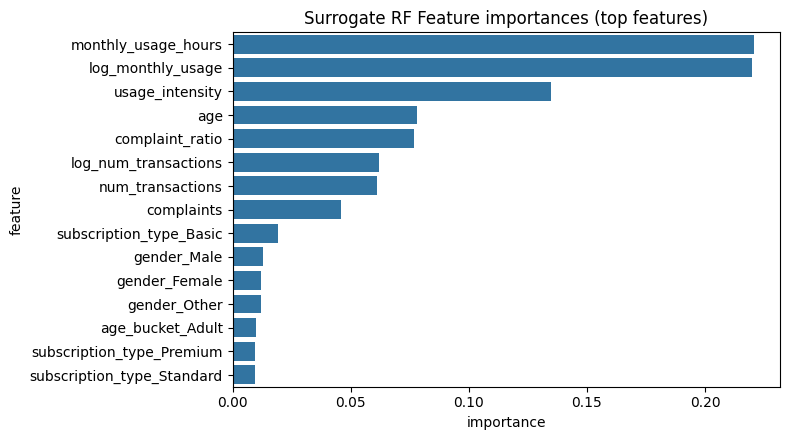

In [ ]:

# get feature names now that preprocessor is fitted
feature_names = get_feature_names(final_pipe.named_steps["preprocessor"])
print("\nFinal feature names (count):", len(feature_names))

fi = None  # so we can safely refer to it later
try:
    # transform X_train to preprocessed array
    X_train_trans = final_pipe.named_steps["preprocessor"].transform(X_train)

    # surrogate RF to approximate feature importances
    rf_for_importance = RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    )
    rf_for_importance.fit(X_train_trans, y_train)

    importances = rf_for_importance.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(TOP_K_FEATURES)

    print("\nTop feature importances (approx, via surrogate RF):")
    print(fi.to_string(index=False))

    # plot
    plt.figure(figsize=(8, max(3, 0.3 * len(fi))))
    sns.barplot(x="importance", y="feature", data=fi)
    plt.title("Surrogate RF Feature importances (top features)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Could not compute surrogate feature importances:", e)




# Save final pipeline & summaries


In [ ]:

# Save model pipeline
joblib.dump(final_pipe, OUTPUT_MODEL_PATH)
print("Saved final pipeline to:", OUTPUT_MODEL_PATH)

# Save metrics + CV summary to CSV
summary_rows = [{
    "model": "Stacking_ensemble",
    "accuracy": test_metrics["accuracy"],
    "precision": test_metrics["precision"],
    "recall": test_metrics["recall"],
    "f1": test_metrics["f1"],
    "roc_auc": test_metrics["roc_auc"]
}]

for r in model_scores:
    summary_rows.append({
        "model": r["model"],
        "mean_roc_auc": r["mean_roc_auc"],
        "std_roc_auc": r["std_roc_auc"]
    })

summary = pd.DataFrame(summary_rows)
summary.to_csv(OUTPUT_SUMMARY_CSV, index=False)
print("Saved model comparison to:", OUTPUT_SUMMARY_CSV)

# Save text summary
with open(OUTPUT_TEXT_SUMMARY, "w") as f:
    f.write("Final selected model: Stacking_ensemble\n\n")
    f.write("Test metrics:\n")
    for k, v in test_metrics.items():
        f.write(f"{k}:\n{v}\n\n")

    f.write("Top features (approx):\n")
    if fi is not None:
        f.write(fi.to_string(index=False))
    else:
        f.write("n/a\n")

print("Saved text summary to:", OUTPUT_TEXT_SUMMARY)

print("\nDone. Model pipeline saved at (local path):", OUTPUT_MODEL_PATH)
print("You can use joblib.load(OUTPUT_MODEL_PATH) to load it.")


Saved final pipeline to: /content/output/best_model_pipeline.pkl
Saved model comparison to: /content/output/model_comparison_summary.csv
Saved text summary to: /content/output/best_model_summary.txt

Done. Model pipeline saved at (local path): /content/output/best_model_pipeline.pkl
You can use joblib.load(OUTPUT_MODEL_PATH) to load it.


In [ ]:
import joblib
import numpy as np
import pandas as pd

# load pipeline
final_pipe = joblib.load("model.pkl")

def add_features(df):
    df = df.copy()
    df["usage_intensity"] = df["monthly_usage_hours"] / (df["num_transactions"] + 1e-6)
    df["complaint_ratio"] = df["complaints"] / (df["num_transactions"] + 1e-6)
    df["log_monthly_usage"] = np.log1p(df["monthly_usage_hours"])
    df["log_num_transactions"] = np.log1p(df["num_transactions"])

    def age_bucket(a):
        if a <= 30:
            return "Young"
        elif a <= 50:
            return "Adult"
        else:
            return "Senior"
    df["age_bucket"] = df["age"].apply(age_bucket)
    return df


In [ ]:
new_customers_raw = pd.DataFrame([
    # 1. Very loyal, heavy user, zero complaints → expected low churn
    {
        "age": 28,
        "gender": "Male",
        "monthly_usage_hours": 120,   # watches a lot
        "num_transactions": 12,       # many payments/renewals
        "complaints": 0,
        "subscription_type": "Premium"
    },
    # 2. Low usage, many complaints, basic plan → expected high churn
    {
        "age": 35,
        "gender": "Female",
        "monthly_usage_hours": 5,
        "num_transactions": 2,
        "complaints": 3,
        "subscription_type": "Basic"
    },
    # 3. Medium usage but very high complaint ratio → likely to churn
    {
        "age": 22,
        "gender": "Male",
        "monthly_usage_hours": 40,
        "num_transactions": 3,
        "complaints": 4,  # more complaints than transactions
        "subscription_type": "Standard"
    },
    # 4. Older user, moderate usage, no complaints, long history → probably stable
    {
        "age": 55,
        "gender": "Female",
        "monthly_usage_hours": 60,
        "num_transactions": 20,
        "complaints": 0,
        "subscription_type": "Standard"
    },
    # 5. New user: very low usage, low transactions, no complaints yet → ambiguous / moderate churn risk
    {
        "age": 30,
        "gender": "Other",
        "monthly_usage_hours": 8,
        "num_transactions": 1,
        "complaints": 0,
        "subscription_type": "Basic"
    },
])

# Add engineered features
new_customers = add_features(new_customers_raw)

# Predict
probs = final_pipe.predict_proba(new_customers)[:, 1]  # probability of churn
preds = final_pipe.predict(new_customers)

for i, (p, prob) in enumerate(zip(preds, probs), start=1):
    print(f"Customer {i}: predicted_churn={p}, churn_probability={prob:.3f}")


Customer 1: predicted_churn=0, churn_probability=0.072
Customer 2: predicted_churn=1, churn_probability=0.812
Customer 3: predicted_churn=0, churn_probability=0.069
Customer 4: predicted_churn=0, churn_probability=0.071
Customer 5: predicted_churn=1, churn_probability=0.559
